In training we get:
Priors P(Y=c): The probability of seeing a specific digit

Means (μc​): The average looking digit for each class (the centroid of the cluster)

Regularized Covariance (Σ): It calculates the Within-Class Scatter, which represents how spread out the data is around the class mean

Regularization: It adds λI to the covariance (reduces overfitting)

c-> class
In prediction: we use this equation Scorec ​= ln(Priorc​) − 0.5​(x−μc​)^T Σ^−1 (x−μc​)
The Result: The class with the highest score is the predicted label

In [21]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

In [22]:
digits = load_digits()
X = digits.data
y = digits.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=17)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=17)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Training Model

In [23]:
def train_gaussian_generative_model(X, Y, lambda_value):
  total_number_of_samples = len(X)
  num_classes = len(np.unique(Y))
  class_labels = np.unique(Y)
  priors = dict(zip(class_labels, np.zeros(num_classes)))
  means = dict(zip(class_labels, np.zeros(num_classes)))
  n_features = X.shape[1]
  within_class_scatter = np.zeros((n_features, n_features))

  for i in range(num_classes):
      current_class = class_labels[i]
      priors[current_class] = np.sum(Y == current_class) / total_number_of_samples
      means[current_class] = np.mean(X[Y == current_class], axis=0)
      within_class_scatter += (X[Y == current_class] - means[current_class]).T.dot(X[Y == current_class] - means[current_class])

  within_class_scatter = within_class_scatter / total_number_of_samples

  regularized_covariance = within_class_scatter + (lambda_value * np.eye(n_features))

  return priors, means, regularized_covariance

# Prediction

In [24]:
def predict(X, priors, means, regularized_covariance):
  # Calculating The Mahalanobis Distance.
  num_classes = len(priors)
  n_samples = X.shape[0]
  predictions = np.zeros(n_samples)
  scores = np.zeros((n_samples, num_classes))

  inverse_covariance = np.linalg.inv(regularized_covariance)

  for i in range(num_classes):
    prior_score = np.log(priors[i])
    Diff = X - means[i]

    scores[:, i] = prior_score + (-0.5 * np.dot(Diff, inverse_covariance) * Diff).sum(axis=1)

  predictions = np.argmax(scores, axis=1)

  return predictions

# Evaluation

In [25]:
# Optimizattion
lambda_values = [1e-4, 1e-3, 1e-2, 1e-1]
best_lambda = None
best_accuracy = 0

for lambda_value in lambda_values:
    priors, means, regularized_covariance = train_gaussian_generative_model(X_train_scaled, y_train, lambda_value)
    y_pred = predict(X_val_scaled, priors, means, regularized_covariance)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Lambda: {lambda_value} -> Validation Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda = lambda_value

print(f"\nBest Lambda found: {best_lambda} with Accuracy: {best_accuracy:.4f}")


Lambda: 0.0001 -> Validation Accuracy: 0.9407
Lambda: 0.001 -> Validation Accuracy: 0.9407
Lambda: 0.01 -> Validation Accuracy: 0.9444
Lambda: 0.1 -> Validation Accuracy: 0.9481

Best Lambda found: 0.1 with Accuracy: 0.9481


Test Accuracy: 0.9667

Classification Report (Macro Avg):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        27
           1     0.9259    0.9259    0.9259        27
           2     1.0000    1.0000    1.0000        27
           3     0.9643    1.0000    0.9818        27
           4     1.0000    0.9630    0.9811        27
           5     1.0000    0.9643    0.9818        28
           6     1.0000    1.0000    1.0000        27
           7     1.0000    0.9630    0.9811        27
           8     0.8333    0.9615    0.8929        26
           9     0.9600    0.8889    0.9231        27

    accuracy                         0.9667       270
   macro avg     0.9684    0.9667    0.9668       270
weighted avg     0.9690    0.9667    0.9671       270


Confusion Matrix:
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  2  0]
 [ 0  0 27  0  0  0  0  0  0  0]
 [ 0  0  0 27  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  0  1  0]

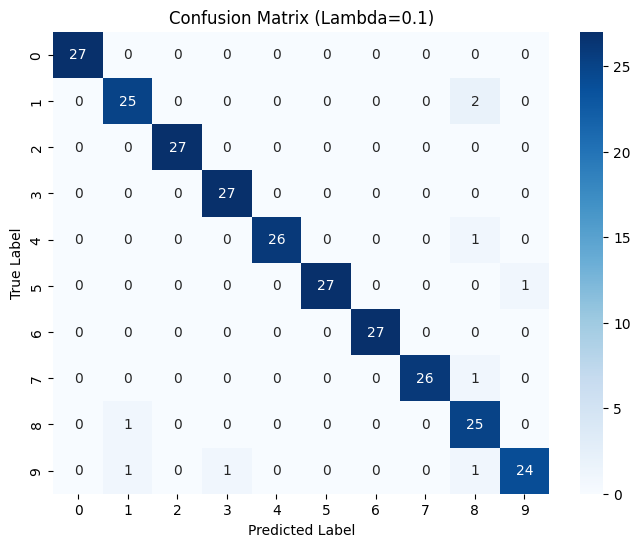

In [26]:
# Best Model

# 1. Combine the already sacled Training and Validation sets stacking the arrays vertically (rows)
X_train_final = np.vstack((X_train_scaled, X_val_scaled))
y_train_final = np.concatenate((y_train, y_val))

priors, means, regularized_covariance = train_gaussian_generative_model(X_train_final, y_train_final, best_lambda)
y_pred = predict(X_test_scaled, priors, means, regularized_covariance)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Macro-averaged metrics
print("\nClassification Report (Macro Avg):")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Lambda={best_lambda})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
